In [5]:
import time, random
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

import tensorflow as tf
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name="weight")

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name="bias")

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name = "activation")

def conv_layer(prev_layer, K, F, S):
    width_prev_layer = int(prev_layer.get_shape()[3])
    Weight_mat = weight_variable([F, F, width_prev_layer, K])
    return tf.nn.conv2d(prev_layer, Weight_mat, strides=[1, S, S, 1], padding='SAME') + bias_variable([K])

def conv_pool_layer(prev_layer, K, F, S, name = ""):
    """
    Convolutional Layer and followed by a pool 2x2 layer

    input:
    prev_layer: The previous layer
    K: Number of filters
    F: Spatial extent (width of each filter)
    S: The stride

    ouput:
    A layer with filters
    Let W be the width of prev. layer
    the output size is W/(2*S)
    """
    name = name if name != "" else str(random.randint(1, 1 << 30))
    with tf.name_scope("Conv_Pool_"+name):
        activation_layer = tf.nn.relu(conv_layer(prev_layer, K, F, S))
        return max_pool_2x2(activation_layer)

def Full_connect_layer(prev_layer, activation, K, name = ""):
    """
    transform the previous layer to a "flat" matrix
    And then fully connect to the next layer

    input:
    prev_layer: The previous layer
    activation: ghd activation function of the nervous
    K: size of the output layer 

    ouput:
    a "flat" matrix with size K
    """
    name = name if name != "" else str(random.randint(1, 1 << 30))
    with tf.name_scope("Full_Connect_"+name):
        sz_prev = int(reduce(lambda x,y: x*y, prev_layer.get_shape()[1:]))
        flat = tf.reshape(prev_layer, [-1, sz_prev])
        Weight = weight_variable([sz_prev, K])
        Bias = bias_variable([K])
        return activation(tf.matmul(flat, Weight) + Bias, name = "activation")

x_image = tf.reshape(x, [-1, 28, 28, 1])

cp1 = conv_pool_layer(x_image, 32, 5, 1, name = "CP1")
cp2 = conv_pool_layer(cp1, 64, 5, 1, name = "CP2")

fc1 = Full_connect_layer(cp2, tf.nn.relu, 1024, name = "FC1")

keep_prob = tf.placeholder(tf.float32)
fc1_drop = tf.nn.dropout(fc1, keep_prob)

y_conv = Full_connect_layer(fc1_drop, tf.nn.softmax, 10, name = "Y_CONV")

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
sess.run(tf.initialize_all_variables())
start_train_time = time.time()

for i in range(500):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict = {
            x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
end_train_time = time.time()

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
print "Total Training Time:",(end_train_time - start_train_time)

step 0, training accuracy 0.16
step 100, training accuracy 0.82
step 200, training accuracy 0.94
step 300, training accuracy 0.82
step 400, training accuracy 0.98
test accuracy 0.9442
Total Training Time: 118.728524923


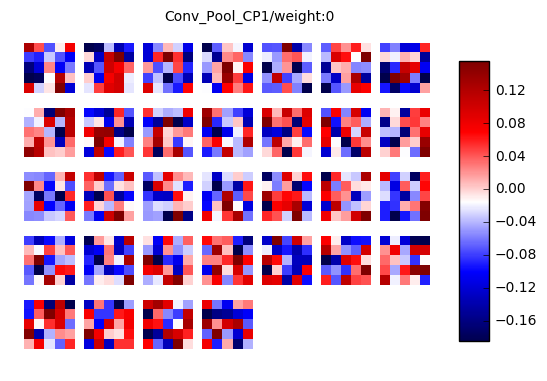

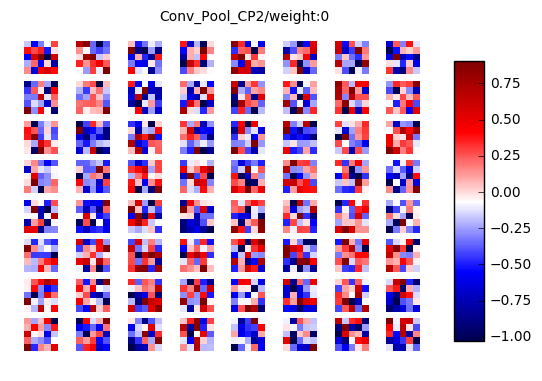

In [98]:
import math
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from IPython.display import Image, display
np.set_printoptions(precision=2)

def conv_img_matrix(Mat):
    assert(int(np.shape(Mat)[0]) == int(np.shape(Mat)[1]))
    W = int(np.shape(Mat)[0])
    K = int(np.shape(Mat)[3])
    return np.array([[[sum(Mat[i, j, :, k]) for i in range(W)] for j in range(W)] for k in range(K)])

Weight_Value = [v for v in tf.trainable_variables() if v.name.find('weight') != -1 and v.name.find('Conv') != -1]

def show_tf_variable(v):
    mat = conv_img_matrix(v.value().eval())
    sz = len(mat)
    h = int(math.sqrt(sz))
    w = int(math.ceil(float(sz)/h))
    fig, axes = plt.subplots(nrows=h, ncols=w)
    i = -1
    for ax in axes.flat:
        ax.set_axis_off()
        i += 1
        if i >= sz: continue 
        im = ax.imshow(mat[i], cmap='seismic', interpolation='nearest')
    fig.suptitle(v.name)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    
for v in Weight_Value:
    show_tf_variable(v)